In [1]:
from typing import List

import torch
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from PIL import Image
import os
import numpy as np

import random
from random import shuffle
from util import show_clean_dirty_images, show_clean_dirty_prediction_images
from model import Denoiser

# Loading the data

In [2]:
random.seed(2)
np.random.seed = 2

# Set Variables
path_train_images_clean = "E:/sheets/dl/train/clean/"
path_train_images_dirty = "E:/sheets/dl/train/dirty/"
path_test_images_clean = "E:/sheets/dl/test/clean/"
path_test_images_dirty = "E:/sheets/dl/test/dirty/"

doc_creator_degenerations = {
    'Bleed_0', 
    'Blur_Complete_0', 
    'CharDeg_0', 
    'Hole_0', 
    'Phantom_FREQUENT_0', 
    'Phantom_RARE_0',
    'Shadow_Bottom',
    'Shadow_Left',
    'Shadow_Right',
    'Shadow_Top'}

a4_size = (3508, 2480)
split_size = 0.85
batch_size = 8

In [3]:
train_images_clean = sorted(os.listdir(path_train_images_clean))
train_images_dirty = sorted(os.listdir(path_train_images_dirty))

test_images_clean = sorted(os.listdir(path_test_images_clean))
test_images_dirty = sorted(os.listdir(path_test_images_dirty))

print(f'Number of Images in train:\n\tclean: {len(train_images_clean)}\n\tdirty: {len(train_images_dirty)}')
print(f'Number of Images in test:\n\tclean: {len(test_images_clean)}\n\tdirty: {len(test_images_dirty)}')

Number of Images in train:
	clean: 4
	dirty: 40
Number of Images in test:
	clean: 1
	dirty: 10


In [4]:
def remove_degeneration_name(file):
    for degeneration in doc_creator_degenerations:
        if degeneration in file:
            return file.replace(degeneration, "")
        
    raise Exception(f'No degeneration encoding found in {file}')

# Defining the Transformations for testing images
transform = transforms.Compose([
	# transforms.Resize((int(a4_size[0]/6), int(a4_size[1]/6))),
    transforms.Resize((584, 412)),
	transforms.ToTensor(), 
	transforms.Normalize(0.5, 0.5)
])

def convert_to_tensor(file):
    return transform(Image.open(file).convert('L'))

def get_pairs_as_list(images_dirty: List[str], images_clean: List[str], path_images_dirty: str, path_images_clean: str):
    # Create a map of the clean image to the dirty images
    pairs = {}
    
    for image_dirty in images_dirty:
        image_clean = remove_degeneration_name(image_dirty)
        
        if image_clean not in pairs: 
            pairs[image_clean] = [image_dirty]
        else:
            pairs[image_clean].append(image_dirty)
            
    images_transform = []

    for image_clean in pairs:
        file_image_clean = os.path.join(path_images_clean, image_clean)
        image_clean_transform = convert_to_tensor(file_image_clean)
        
        for image_dirty in pairs[image_clean]:
             file_image_dirty = os.path.join(path_images_dirty, image_dirty)
             image_dirty_transform = convert_to_tensor(file_image_dirty)
             images_transform.append((image_dirty_transform, image_clean_transform))
            
    return images_transform

In [5]:
train_images = get_pairs_as_list(train_images_dirty, train_images_clean, path_train_images_dirty, path_train_images_clean)
test_images = get_pairs_as_list(test_images_dirty, test_images_clean, path_test_images_dirty, path_test_images_clean)

In [6]:
shuffle(train_images)

## Show some images

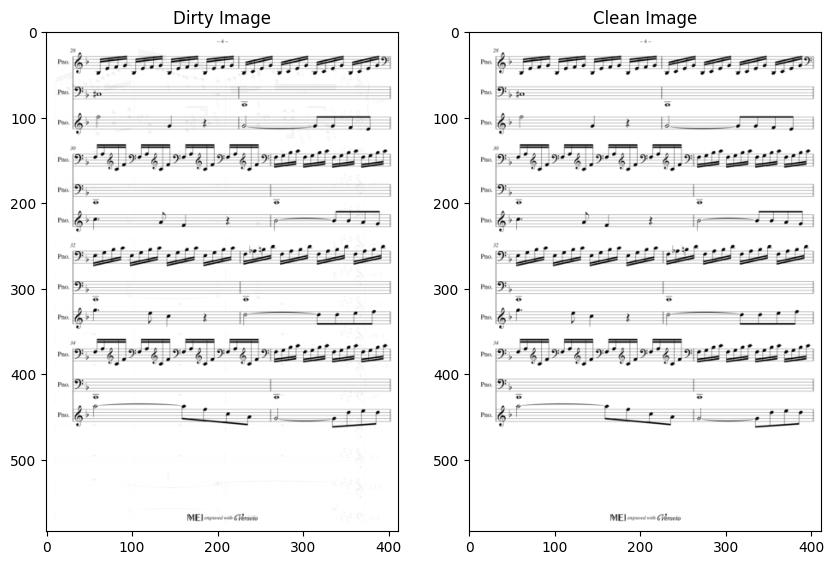

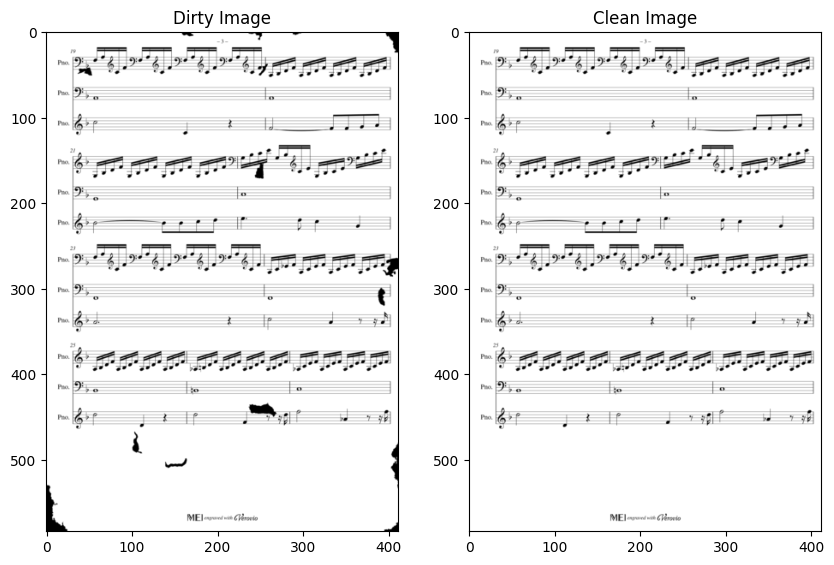

In [7]:
show_clean_dirty_images(train_images[10][0], train_images[10][1])
show_clean_dirty_images(train_images[36][0], train_images[36][1])

In [8]:
index = int(len(train_images)*split_size)

train_dataset = train_images[:index]
valid_dataset = train_images[index:]

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Defining the Model and Hyperparameters

In [9]:
model = Denoiser()
print(model)

Denoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convt_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convt_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convt_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [10]:
# defining the loss function
criterion = nn.MSELoss()

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
cuda_available = torch.cuda.is_available()

if cuda_available:
	print('Cuda available...\tTraining on GPU')
	model = model.cuda()
else:
	print('CUDA not available...\tTraining on CPU')

CUDA not available...	Training on CPU


# Training

In [17]:
import matplotlib.pyplot as plt

epochs = 100
training_loss = 0
min_valid_loss = np.Inf
save_path = "../save/model.pth"

for e in range(epochs):
    
    for images, targets in train_loader:
        if cuda_available:
            images, targets = images.cuda(), targets.cuda()
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
    
    with torch.no_grad():
        
        valid_loss = 0
        
        for images, targets in valid_loader:
            if cuda_available:
                images, targets = images.cuda(), targets.cuda()
        
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            valid_loss += loss.item()
    
        if valid_loss < min_valid_loss:
            print('Loss Decreased..({:.3f} -> {:.3f})  Saving Model..'.format(valid_loss, min_valid_loss))
            torch.save(model.state_dict(), save_path)
            min_valid_loss = valid_loss/len(valid_loader)
            
    print('Epoch: {}/{} -- Training Loss: {:.3f} -- Testing Loss: {:.3f}'.format(e+1, epochs, training_loss/len(train_loader), \
                                                                                 valid_loss/len(valid_loader)))
    training_loss = 0

Loss Decreased..(0.050 -> inf)  Saving Model..
Epoch: 1/100 -- Training Loss: 0.052 -- Testing Loss: 0.050
Loss Decreased..(0.049 -> 0.050)  Saving Model..
Epoch: 2/100 -- Training Loss: 0.050 -- Testing Loss: 0.049
Loss Decreased..(0.048 -> 0.049)  Saving Model..
Epoch: 3/100 -- Training Loss: 0.048 -- Testing Loss: 0.048
Loss Decreased..(0.046 -> 0.048)  Saving Model..
Epoch: 4/100 -- Training Loss: 0.046 -- Testing Loss: 0.046
Loss Decreased..(0.045 -> 0.046)  Saving Model..
Epoch: 5/100 -- Training Loss: 0.044 -- Testing Loss: 0.045
Loss Decreased..(0.044 -> 0.045)  Saving Model..
Epoch: 6/100 -- Training Loss: 0.043 -- Testing Loss: 0.044
Loss Decreased..(0.044 -> 0.044)  Saving Model..
Epoch: 7/100 -- Training Loss: 0.042 -- Testing Loss: 0.044
Loss Decreased..(0.042 -> 0.044)  Saving Model..
Epoch: 8/100 -- Training Loss: 0.041 -- Testing Loss: 0.042
Loss Decreased..(0.041 -> 0.042)  Saving Model..
Epoch: 9/100 -- Training Loss: 0.041 -- Testing Loss: 0.041
Loss Decreased..(0.04

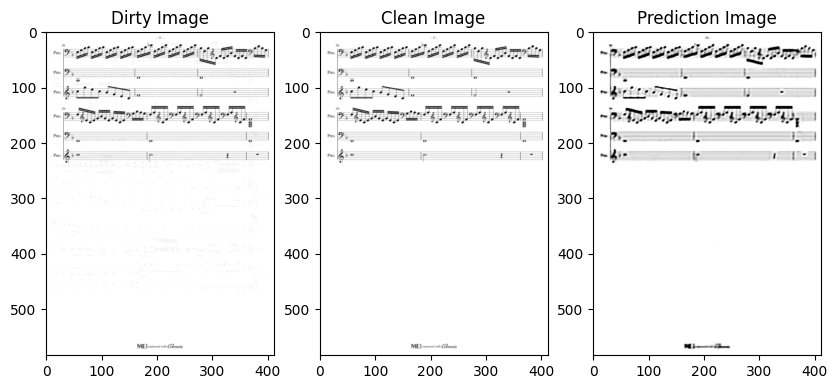

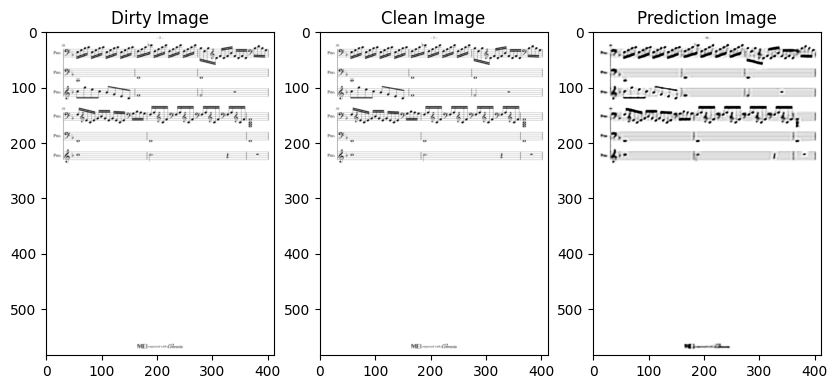

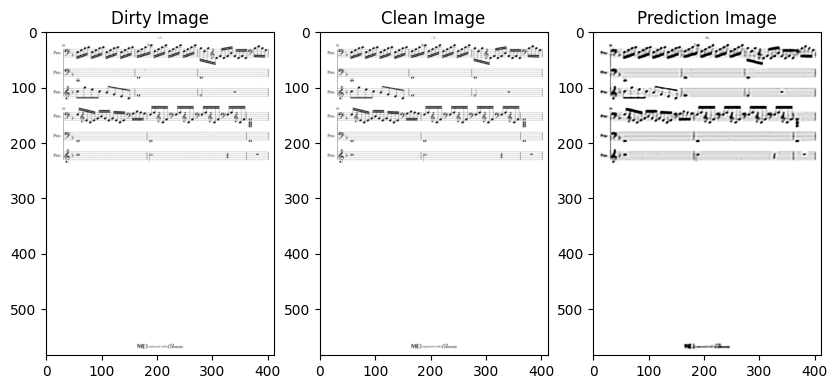

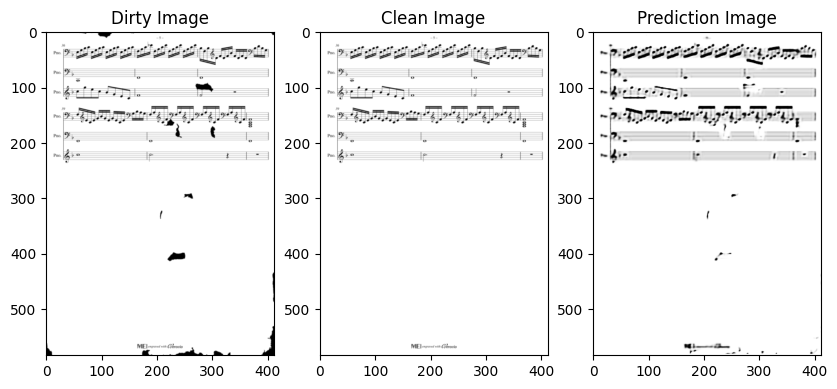

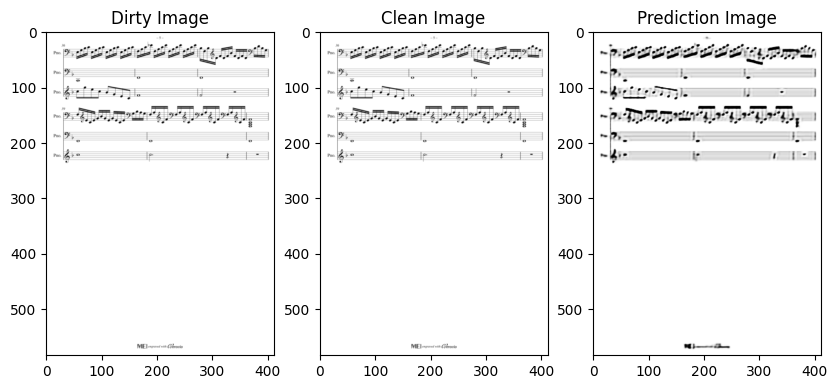

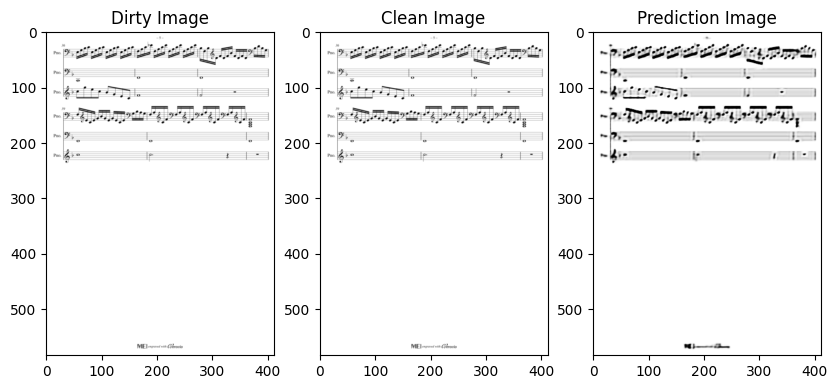

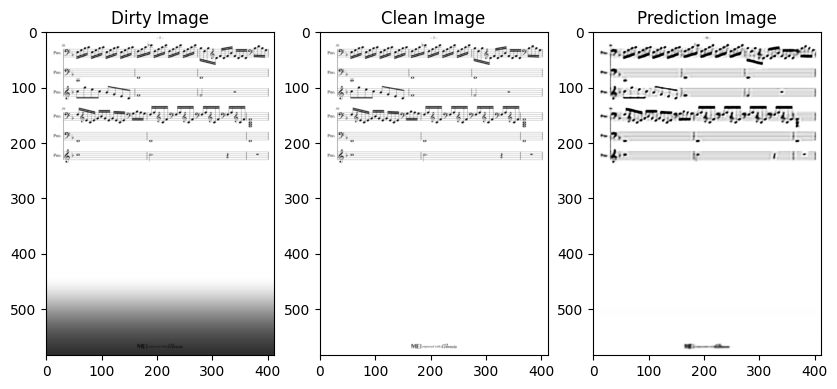

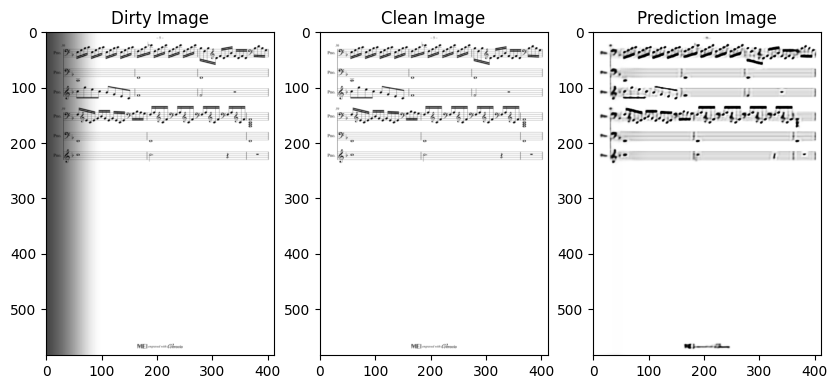

In [18]:
for cleans, dirties in DataLoader(test_images, batch_size=batch_size):
    outputs = model(cleans)
    
    for i in range(batch_size):
        show_clean_dirty_prediction_images(cleans[i], dirties[i], outputs[i].detach())
    break